In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..') # for library importing

In [2]:
import torchvision
from torchvision import transforms

from utils import *
from data_loader import RescaleT, RandomCrop, ToTensorLab

In [3]:
class PatSegDataset():
    def __init__(self, annotation_file, 
                 frame_root="/data/GaitData/RawFrames", transform=None):
        
        self.anno = load_annotation(annotation_file, frame_root)
        self.transform = transform
        
    def __len__(self):
        return len(self.anno)
    
    def __getitem__(self, idx):
        filename = self.anno.path.iloc[idx]
        
        image  = Image.open(filename)
        label  = get_mask_label(self.anno, filename, visualize=False)
        
        image = np.array(image)
        label = np.array(label)[..., np.newaxis] # add last channel
        imidx = np.array([idx])
                
        sample = {'imidx': imidx, 'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
                        
        return sample

In [4]:
anno_file = "../data/person_detection_and_tracking_results_drop-Gaitparams_PD.pkl"
frame_root = '/data/GaitData/RawFrames'

ds = PatSegDataset(anno_file, frame_root, 
                   transform=transforms.Compose([
                       RescaleT(320),
                       RandomCrop(288),
                       ToTensorLab(flag=0)]))

Total:  672138


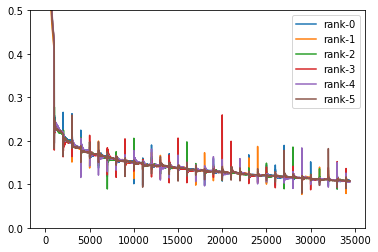

In [33]:
def plot_training_loss(rank=0):
    log_file = "../logs/u2net/rank.{}/stdout".format(rank)
    train_loss = []
    for line in open(log_file):
        if "train loss: " in line:
            loss_val = eval(line[line.index("train loss: "):line.index("tar: ")-2].replace("train loss: ", ""))
            train_loss.append(loss_val)
    plt.plot(train_loss, label='rank-{}'.format(rank))
    plt.ylim(0, 0.5)

n_ranks = 6
for i in range(n_ranks):
    plot_training_loss(i)
    
plt.legend()